# Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Reading the image

In [ ]:
img = cv2.imread('/content/drive/MyDrive/input_root.png')[:,:,::-1]
img = cv2.resize(img, (800, 600))

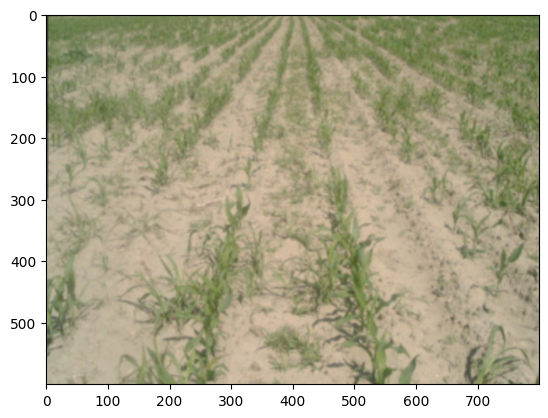

In [ ]:
plt.imshow(img)

# Stage one

Text(0.5, 1.0, 'Blue Channle')

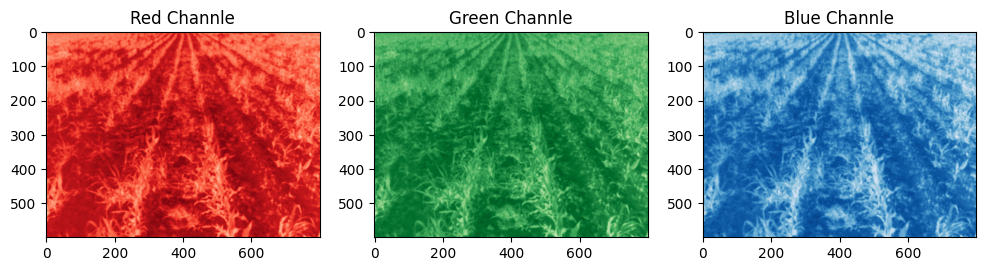

In [ ]:
R_channle = img[:,:,0]
G_channle = img[:,:,1]
B_channle = img[:,:,2]

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 15))
ax[0].imshow(R_channle, cmap = "Reds")
ax[0].set_title("Red Channle")

ax[1].imshow(G_channle, cmap = "Greens")
ax[1].set_title("Green Channle")

ax[2].imshow(B_channle, cmap = "Blues")
ax[2].set_title("Blue Channle")

Text(0.5, 1.0, 'COM')

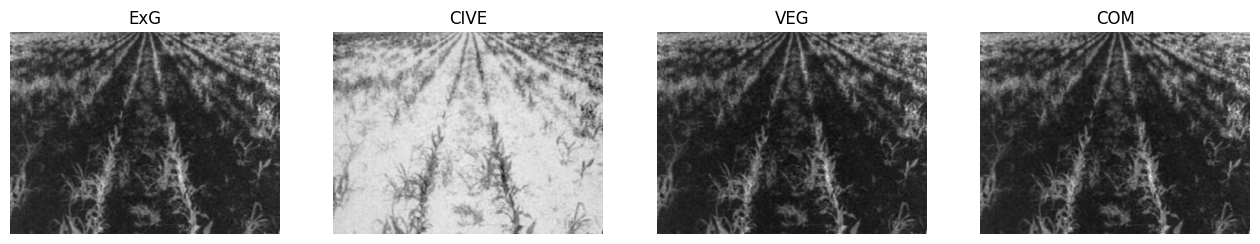

In [ ]:
Rn = R_channle / 255.
Gn = G_channle / 255.
Bn = B_channle / 255.

r = Rn / (Rn + Gn + Bn)
b = Bn / (Rn + Gn + Bn)
g = Gn / (Rn + Gn + Bn)

ExG = 2*g - r - b

CIVE = 0.441*r - 0.811*g + 0.385*b + 18.78745

a = 0.667
VEG = g / ((r**a) * (b**(1-a)))

COM = 0.36*ExG + 0.47*CIVE + 0.17*VEG

fig, ax = plt.subplots(nrows=1, ncols = 4, figsize = (16, 20))
ax[0].imshow(ExG, cmap = 'gray')
ax[0].axis("off")
ax[0].set_title("ExG")

ax[1].imshow(CIVE, cmap = 'gray')
ax[1].axis("off")
ax[1].set_title("CIVE")

ax[2].imshow(VEG, cmap = 'gray')
ax[2].axis("off")
ax[2].set_title("VEG")

ax[3].imshow(COM, cmap = 'gray')
ax[3].axis("off")
ax[3].set_title("COM")

Text(0.5, 1.0, 'int_COM')

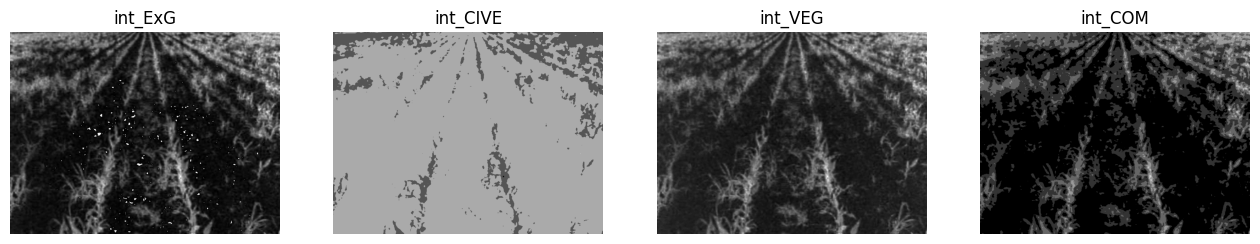

In [ ]:
max_val = COM.max()
normalized_COM = COM / max_val
int_COM = (normalized_COM * 255).astype('uint8')

max_val = ExG.max()
normalized_ExG = ExG / max_val
int_ExG = (normalized_ExG * 255).astype('uint8')

max_val = CIVE.max()
normalized_CIVE = CIVE / max_val
int_CIVE = (normalized_CIVE * 255).astype('uint8')

max_val = VEG.max()
normalized_VEG = VEG / max_val
int_VEG = (normalized_VEG * 255).astype('uint8')

fig, ax = plt.subplots(nrows=1, ncols = 4, figsize = (16, 20))
ax[0].imshow(int_ExG, cmap = 'gray')
ax[0].axis("off")
ax[0].set_title("int_ExG")

ax[1].imshow(int_CIVE, cmap = 'gray')
ax[1].axis("off")
ax[1].set_title("int_CIVE")

ax[2].imshow(int_VEG, cmap = 'gray')
ax[2].axis("off")
ax[2].set_title("int_VEG")

ax[3].imshow(int_COM, cmap = 'gray')
ax[3].axis("off")
ax[3].set_title("int_COM")

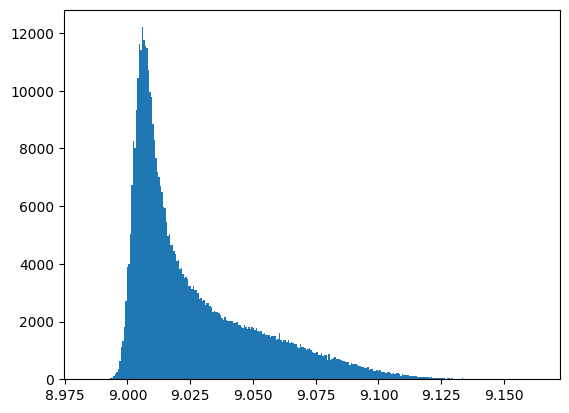

In [ ]:
plt.hist(COM.flatten(), bins=300);

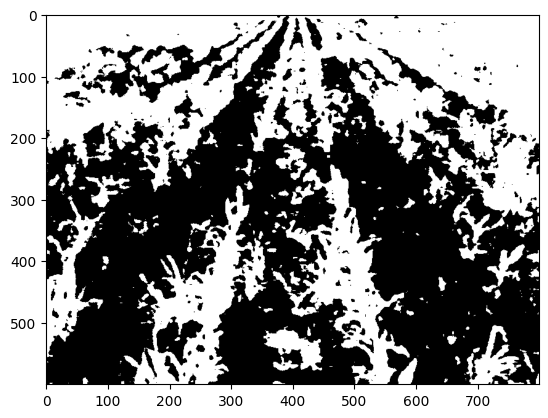

In [ ]:
ret, thresh1 = cv2.threshold(int_COM, 112 , 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh1, cmap = 'gray')

# stage 2

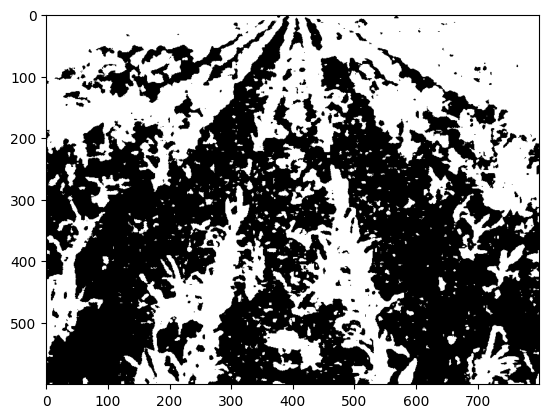

In [ ]:
inverted_threshold = cv2.bitwise_not(thresh1)

ret, thresh2 = cv2.threshold((inverted_threshold)*int_ExG, 83, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh2 = cv2.bitwise_not(thresh2)
plt.imshow(thresh2, cmap = 'gray')

# Stage 3

In [ ]:
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import binary_erosion

In [ ]:
def opening(image, selem_size=3):
    # Define structuring element as square of size selem_size
    selem = np.ones((selem_size, selem_size), dtype=np.uint8)

    # Perform erosion and dilation operations
    eroded = cv2.erode(image, selem)
    opened = cv2.dilate(eroded, selem)

    return opened


def majority(image):
    kernel = np.ones((3, 3), dtype=bool)
    kernel[1, 1] = False
    
    def majority_filter(values):
        if np.sum(values == 0) >= 5:
            return 0
        else:
            return 1
    
    filtered_image = generic_filter(image, majority_filter, footprint=kernel)
    return filtered_image.astype(np.uint8)



def cleaning(image):
    # Define structuring element as 3x3 array of ones
    selem = np.ones((3, 3), dtype=np.uint8)

    # Perform erosion and dilation operations
    eroded = cv2.erode(image, selem)
    dilated = cv2.dilate(eroded, selem)

    # Identify isolated pixels as white pixels surrounded by black pixels
    isolated_pixels = np.logical_and(image == 1, dilated == 0)

    # Remove isolated pixels from original image
    cleaned = np.copy(image)
    cleaned[isolated_pixels] = 0

    return cleaned

In [ ]:
first_op = opening(thresh2, 3)
second_op = majority(first_op)
final_op = cleaning(second_op)

Text(0.5, 1.0, 'after cleaning')

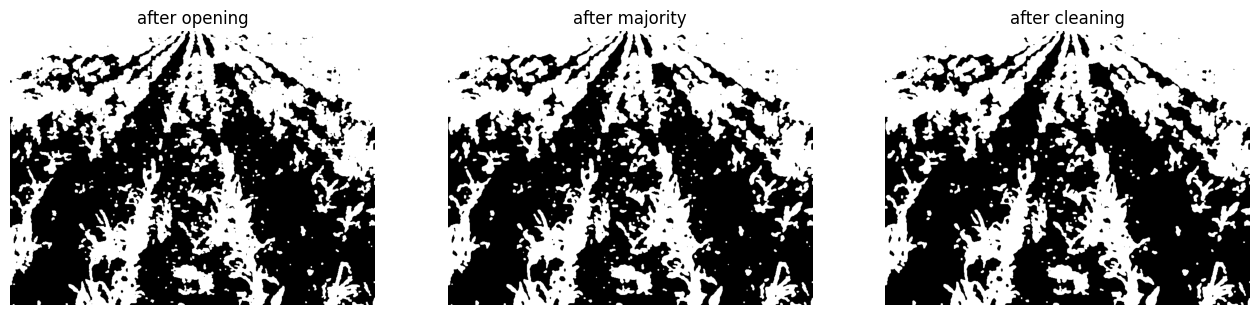

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (16, 20))
ax[0].imshow(first_op, cmap='gray')
ax[0].axis("off")
ax[0].set_title("after opening")

ax[1].imshow(second_op, cmap='gray')
ax[1].axis("off")
ax[1].set_title("after majority")

ax[2].imshow(final_op, cmap='gray')
ax[2].axis("off")
ax[2].set_title("after cleaning")

In [ ]:
result = cv2.addWeighted(thresh1, 0.5, (final_op), 0.5, 0)

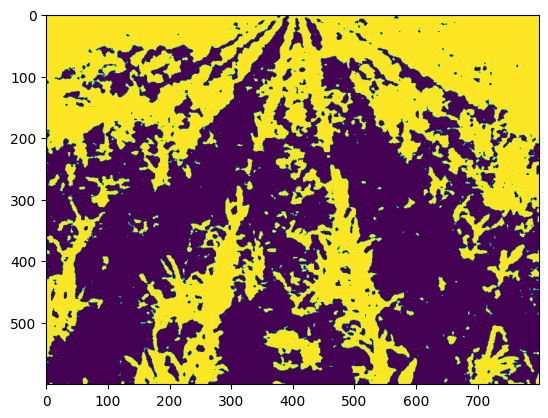

In [ ]:
plt.imshow(result)